# Tutorial: creación de ETLs con PySpark

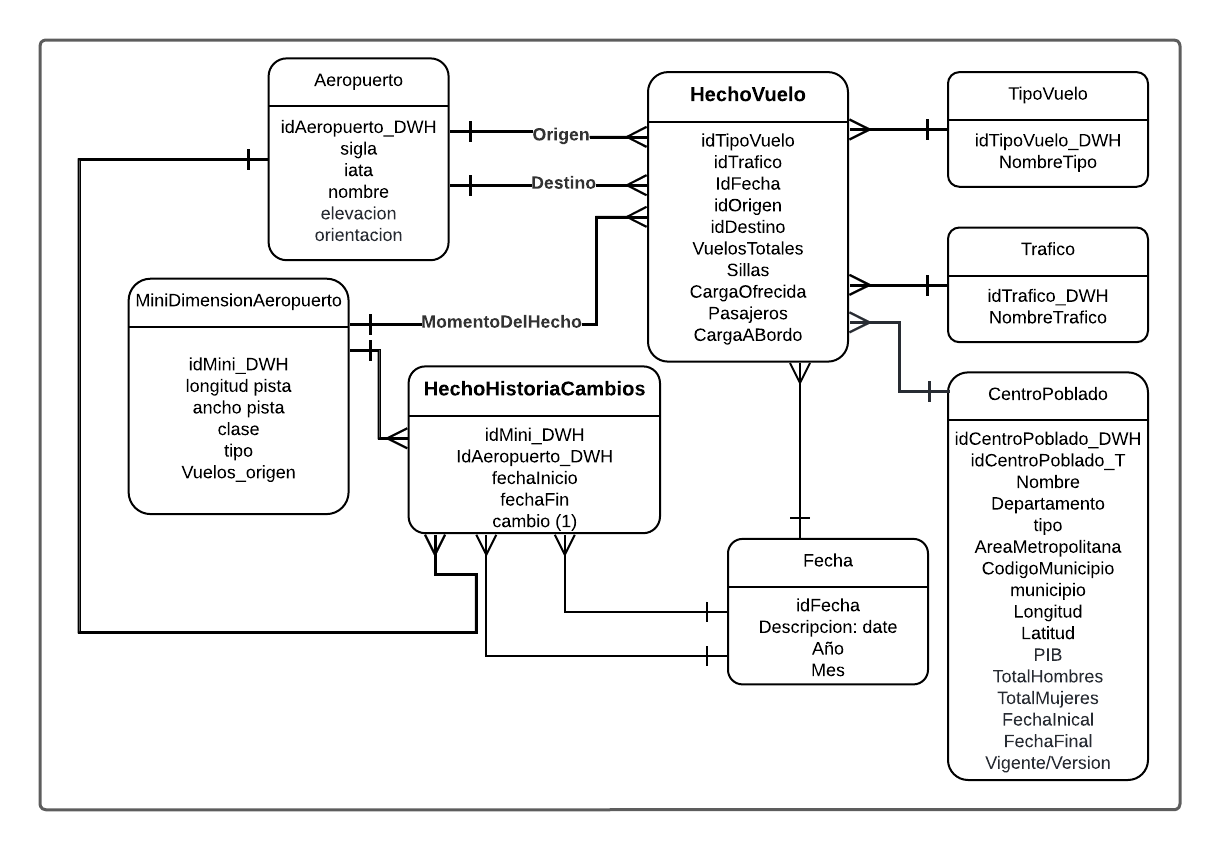!

### Se agrega pyspark 

In [1]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 44.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=aa86d7ae9cac51d805d0148884b10eca70953fffc235e64403b88cf41b84ae94
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


### Se configuran Bases de datos

In [2]:
db_user = 'Estudiante_50'
db_psswd = 'VW3VMM0YEO'
source_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
dest_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/Estudiante_50'

# Driver de conexion
path_jar_driver = '/content/mysql-connector-java-8.0.28.jar'

In [3]:
import os 
from pyspark.sql import functions as f, SparkSession, types as t
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf, col, length, isnan, when, count, regexp_replace
from datetime import datetime

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


### Funciones

In [5]:
def obterner_dataframe_desde_csv(_PATH, _sep):
    return spark.read.load(_PATH, format="csv", sep=_sep, inferSchema="true", header='true')

def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

#FECHA

### Extracción Fechas

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
sql_fechas = '''(SELECT  DISTINCT CONVERT( concat( CONVERT(ano,CHAR), "-", CONVERT(mes,CHAR) ,"-01") , DATE) Descripcion , ano Año, mes Mes  FROM ProyectoTransaccional.vuelos  ORDER BY Descripcion) AS Temp_fechas'''
Fecha = obtener_dataframe_de_bd(source_db_connection_string, sql_fechas, db_user, db_psswd)
Fecha.toPandas()

,Descripcion,Año,Mes
0,2004-01-01,2004,1
1,2004-02-01,2004,2
2,2004-03-01,2004,3
3,2004-04-01,2004,4
4,2004-05-01,2004,5
...,...,...,...
163,2017-08-01,2017,8
164,2017-09-01,2017,9
165,2017-10-01,2017,10
166,2017-11-01,2017,11


### Transformación Fechas
Se adiciona la columna con identificador único

In [8]:
# TRANSFORMACION
Fecha = Fecha.withColumn('idFecha', f.monotonically_increasing_id() + 1)
Fecha.toPandas()

,Descripcion,Año,Mes,idFecha
0,2004-01-01,2004,1,1
1,2004-02-01,2004,2,2
2,2004-03-01,2004,3,3
3,2004-04-01,2004,4,4
4,2004-05-01,2004,5,5
...,...,...,...,...
163,2017-08-01,2017,8,164
164,2017-09-01,2017,9,165
165,2017-10-01,2017,10,166
166,2017-11-01,2017,11,167


#### Carga Fechas
Una vez realizado esto, se guardan los resultados en la base de datos destino

In [9]:
# CARGUE
guardar_db(dest_db_connection_string, Fecha, db_user+".Fecha", db_user, db_psswd)

# CentroPoblado


#### Extracción CentroPoblado, PIB , proyecciones

In [10]:
#EXTRACCION

#divipola
sql_ciudad = '''( SELECT  DISTINCT `divipola`.`Codigo Centro Poblado` idCentroPoblado_T,`divipola`.`Nombre Centro Poblado` Nombre, 
`divipola`.`Nombre Departamento` Departamento, 
`divipola`.`Codigo Departamento` coddpto,
`divipola`.`Tipo Centro Poblado` tipo,
`divipola`.`Nombre Area Metropolitana` AreaMetropolitana,
`divipola`.`Unnamed: 1` CodigoMunicipio,
`divipola`.`Nombre Municipio` municipio,Longitud,Latitud, 
0 PIB,
0 TotalHombres,
0 TotalMujeres,
 "SI" as "Vigente/Version" 
 FROM ProyectoTransaccional.divipola 
 ) as tmp_centros '''

centros1 = obtener_dataframe_de_bd(source_db_connection_string, sql_ciudad, db_user, db_psswd)

#PIB
sql_pib = '''(SELECT `PIB`.`CÃ³digo Departamento (DIVIPOLA)` coddpto,
    `PIB`.`DEPARTAMENTOS`,
    `PIB`.`2006`,
    `PIB`.`2007`,
    `PIB`.`2008`,
    `PIB`.`2010`,
    `PIB`.`2011`,
    `PIB`.`2012`,
    `PIB`.`2013`,
    `PIB`.`2014`,
    `PIB`.`2015`,
    `PIB`.`2016`,
    `PIB`.`2017`,
    `PIB`.`2009`,
    `PIB`.`2005`
FROM `ProyectoTransaccional`.`PIB`
 ) as tmp_pib '''

pib = obtener_dataframe_de_bd(source_db_connection_string, sql_pib, db_user, db_psswd)

#Proyecciones
sql_proy = '''(SELECT `proyecciones`.`DP`,
    `proyecciones`.`DPNOM`,
    `proyecciones`.`AÑO` ano,
    `proyecciones`.`AREA GEOGRAFICA`,
    `proyecciones`.`Hombres_0`,
    `proyecciones`.`Hombres_1`,
    `proyecciones`.`Hombres_2`,
    `proyecciones`.`Hombres_3`,
    `proyecciones`.`Hombres_4`,
    `proyecciones`.`Hombres_5`,
    `proyecciones`.`Hombres_6`,
    `proyecciones`.`Hombres_7`,
    `proyecciones`.`Hombres_8`,
    `proyecciones`.`Hombres_9`,
    `proyecciones`.`Hombres_10`,
    `proyecciones`.`Hombres_11`,
    `proyecciones`.`Hombres_12`,
    `proyecciones`.`Hombres_13`,
    `proyecciones`.`Hombres_14`,
    `proyecciones`.`Hombres_15`,
    `proyecciones`.`Hombres_16`,
    `proyecciones`.`Hombres_17`,
    `proyecciones`.`Hombres_18`,
    `proyecciones`.`Hombres_19`,
    `proyecciones`.`Hombres_20`,
    `proyecciones`.`Hombres_21`,
    `proyecciones`.`Hombres_22`,
    `proyecciones`.`Hombres_23`,
    `proyecciones`.`Hombres_24`,
    `proyecciones`.`Hombres_25`,
    `proyecciones`.`Hombres_26`,
    `proyecciones`.`Hombres_27`,
    `proyecciones`.`Hombres_28`,
    `proyecciones`.`Hombres_29`,
    `proyecciones`.`Hombres_30`,
    `proyecciones`.`Hombres_31`,
    `proyecciones`.`Hombres_32`,
    `proyecciones`.`Hombres_33`,
    `proyecciones`.`Hombres_34`,
    `proyecciones`.`Hombres_35`,
    `proyecciones`.`Hombres_36`,
    `proyecciones`.`Hombres_37`,
    `proyecciones`.`Hombres_38`,
    `proyecciones`.`Hombres_39`,
    `proyecciones`.`Hombres_40`,
    `proyecciones`.`Hombres_41`,
    `proyecciones`.`Hombres_42`,
    `proyecciones`.`Hombres_43`,
    `proyecciones`.`Hombres_44`,
    `proyecciones`.`Hombres_45`,
    `proyecciones`.`Hombres_46`,
    `proyecciones`.`Hombres_47`,
    `proyecciones`.`Hombres_48`,
    `proyecciones`.`Hombres_49`,
    `proyecciones`.`Hombres_50`,
    `proyecciones`.`Hombres_51`,
    `proyecciones`.`Hombres_52`,
    `proyecciones`.`Hombres_53`,
    `proyecciones`.`Hombres_54`,
    `proyecciones`.`Hombres_55`,
    `proyecciones`.`Hombres_56`,
    `proyecciones`.`Hombres_57`,
    `proyecciones`.`Hombres_58`,
    `proyecciones`.`Hombres_59`,
    `proyecciones`.`Hombres_60`,
    `proyecciones`.`Hombres_61`,
    `proyecciones`.`Hombres_62`,
    `proyecciones`.`Hombres_63`,
    `proyecciones`.`Hombres_64`,
    `proyecciones`.`Hombres_65`,
    `proyecciones`.`Hombres_66`,
    `proyecciones`.`Hombres_67`,
    `proyecciones`.`Hombres_68`,
    `proyecciones`.`Hombres_69`,
    `proyecciones`.`Hombres_70`,
    `proyecciones`.`Hombres_71`,
    `proyecciones`.`Hombres_72`,
    `proyecciones`.`Hombres_73`,
    `proyecciones`.`Hombres_74`,
    `proyecciones`.`Hombres_75`,
    `proyecciones`.`Hombres_76`,
    `proyecciones`.`Hombres_77`,
    `proyecciones`.`Hombres_78`,
    `proyecciones`.`Hombres_79`,
    `proyecciones`.`Hombres_80`,
    `proyecciones`.`Hombres_81`,
    `proyecciones`.`Hombres_82`,
    `proyecciones`.`Hombres_83`,
    `proyecciones`.`Hombres_84`,
    `proyecciones`.`Hombres_85`,
    `proyecciones`.`Hombres_86`,
    `proyecciones`.`Hombres_87`,
    `proyecciones`.`Hombres_88`,
    `proyecciones`.`Hombres_89`,
    `proyecciones`.`Hombres_90`,
    `proyecciones`.`Hombres_91`,
    `proyecciones`.`Hombres_92`,
    `proyecciones`.`Hombres_93`,
    `proyecciones`.`Hombres_94`,
    `proyecciones`.`Hombres_95`,
    `proyecciones`.`Hombres_96`,
    `proyecciones`.`Hombres_97`,
    `proyecciones`.`Hombres_98`,
    `proyecciones`.`Hombres_99`,
    `proyecciones`.`Hombres_100 y más`,
    `proyecciones`.`Mujeres_0`,
    `proyecciones`.`Mujeres_1`,
    `proyecciones`.`Mujeres_2`,
    `proyecciones`.`Mujeres_3`,
    `proyecciones`.`Mujeres_4`,
    `proyecciones`.`Mujeres_5`,
    `proyecciones`.`Mujeres_6`,
    `proyecciones`.`Mujeres_7`,
    `proyecciones`.`Mujeres_8`,
    `proyecciones`.`Mujeres_9`,
    `proyecciones`.`Mujeres_10`,
    `proyecciones`.`Mujeres_11`,
    `proyecciones`.`Mujeres_12`,
    `proyecciones`.`Mujeres_13`,
    `proyecciones`.`Mujeres_14`,
    `proyecciones`.`Mujeres_15`,
    `proyecciones`.`Mujeres_16`,
    `proyecciones`.`Mujeres_17`,
    `proyecciones`.`Mujeres_18`,
    `proyecciones`.`Mujeres_19`,
    `proyecciones`.`Mujeres_20`,
    `proyecciones`.`Mujeres_21`,
    `proyecciones`.`Mujeres_22`,
    `proyecciones`.`Mujeres_23`,
    `proyecciones`.`Mujeres_24`,
    `proyecciones`.`Mujeres_25`,
    `proyecciones`.`Mujeres_26`,
    `proyecciones`.`Mujeres_27`,
    `proyecciones`.`Mujeres_28`,
    `proyecciones`.`Mujeres_29`,
    `proyecciones`.`Mujeres_30`,
    `proyecciones`.`Mujeres_31`,
    `proyecciones`.`Mujeres_32`,
    `proyecciones`.`Mujeres_33`,
    `proyecciones`.`Mujeres_34`,
    `proyecciones`.`Mujeres_35`,
    `proyecciones`.`Mujeres_36`,
    `proyecciones`.`Mujeres_37`,
    `proyecciones`.`Mujeres_38`,
    `proyecciones`.`Mujeres_39`,
    `proyecciones`.`Mujeres_40`,
    `proyecciones`.`Mujeres_41`,
    `proyecciones`.`Mujeres_42`,
    `proyecciones`.`Mujeres_43`,
    `proyecciones`.`Mujeres_44`,
    `proyecciones`.`Mujeres_45`,
    `proyecciones`.`Mujeres_46`,
    `proyecciones`.`Mujeres_47`,
    `proyecciones`.`Mujeres_48`,
    `proyecciones`.`Mujeres_49`,
    `proyecciones`.`Mujeres_50`,
    `proyecciones`.`Mujeres_51`,
    `proyecciones`.`Mujeres_52`,
    `proyecciones`.`Mujeres_53`,
    `proyecciones`.`Mujeres_54`,
    `proyecciones`.`Mujeres_55`,
    `proyecciones`.`Mujeres_56`,
    `proyecciones`.`Mujeres_57`,
    `proyecciones`.`Mujeres_58`,
    `proyecciones`.`Mujeres_59`,
    `proyecciones`.`Mujeres_60`,
    `proyecciones`.`Mujeres_61`,
    `proyecciones`.`Mujeres_62`,
    `proyecciones`.`Mujeres_63`,
    `proyecciones`.`Mujeres_64`,
    `proyecciones`.`Mujeres_65`,
    `proyecciones`.`Mujeres_66`,
    `proyecciones`.`Mujeres_67`,
    `proyecciones`.`Mujeres_68`,
    `proyecciones`.`Mujeres_69`,
    `proyecciones`.`Mujeres_70`,
    `proyecciones`.`Mujeres_71`,
    `proyecciones`.`Mujeres_72`,
    `proyecciones`.`Mujeres_73`,
    `proyecciones`.`Mujeres_74`,
    `proyecciones`.`Mujeres_75`,
    `proyecciones`.`Mujeres_76`,
    `proyecciones`.`Mujeres_77`,
    `proyecciones`.`Mujeres_78`,
    `proyecciones`.`Mujeres_79`,
    `proyecciones`.`Mujeres_80`,
    `proyecciones`.`Mujeres_81`,
    `proyecciones`.`Mujeres_82`,
    `proyecciones`.`Mujeres_83`,
    `proyecciones`.`Mujeres_84`,
    `proyecciones`.`Mujeres_85`,
    `proyecciones`.`Mujeres_86`,
    `proyecciones`.`Mujeres_87`,
    `proyecciones`.`Mujeres_88`,
    `proyecciones`.`Mujeres_89`,
    `proyecciones`.`Mujeres_90`,
    `proyecciones`.`Mujeres_91`,
    `proyecciones`.`Mujeres_92`,
    `proyecciones`.`Mujeres_93`,
    `proyecciones`.`Mujeres_94`,
    `proyecciones`.`Mujeres_95`,
    `proyecciones`.`Mujeres_96`,
    `proyecciones`.`Mujeres_97`,
    `proyecciones`.`Mujeres_98`,
    `proyecciones`.`Mujeres_99`,
    `proyecciones`.`Mujeres_100 y más`,
    `proyecciones`.`Total_0`,
    `proyecciones`.`Total_1`,
    `proyecciones`.`Total_2`,
    `proyecciones`.`Total_3`,
    `proyecciones`.`Total_4`,
    `proyecciones`.`Total_5`,
    `proyecciones`.`Total_6`,
    `proyecciones`.`Total_7`,
    `proyecciones`.`Total_8`,
    `proyecciones`.`Total_9`,
    `proyecciones`.`Total_10`,
    `proyecciones`.`Total_11`,
    `proyecciones`.`Total_12`,
    `proyecciones`.`Total_13`,
    `proyecciones`.`Total_14`,
    `proyecciones`.`Total_15`,
    `proyecciones`.`Total_16`,
    `proyecciones`.`Total_17`,
    `proyecciones`.`Total_18`,
    `proyecciones`.`Total_19`,
    `proyecciones`.`Total_20`,
    `proyecciones`.`Total_21`,
    `proyecciones`.`Total_22`,
    `proyecciones`.`Total_23`,
    `proyecciones`.`Total_24`,
    `proyecciones`.`Total_25`,
    `proyecciones`.`Total_26`,
    `proyecciones`.`Total_27`,
    `proyecciones`.`Total_28`,
    `proyecciones`.`Total_29`,
    `proyecciones`.`Total_30`,
    `proyecciones`.`Total_31`,
    `proyecciones`.`Total_32`,
    `proyecciones`.`Total_33`,
    `proyecciones`.`Total_34`,
    `proyecciones`.`Total_35`,
    `proyecciones`.`Total_36`,
    `proyecciones`.`Total_37`,
    `proyecciones`.`Total_38`,
    `proyecciones`.`Total_39`,
    `proyecciones`.`Total_40`,
    `proyecciones`.`Total_41`,
    `proyecciones`.`Total_42`,
    `proyecciones`.`Total_43`,
    `proyecciones`.`Total_44`,
    `proyecciones`.`Total_45`,
    `proyecciones`.`Total_46`,
    `proyecciones`.`Total_47`,
    `proyecciones`.`Total_48`,
    `proyecciones`.`Total_49`,
    `proyecciones`.`Total_50`,
    `proyecciones`.`Total_51`,
    `proyecciones`.`Total_52`,
    `proyecciones`.`Total_53`,
    `proyecciones`.`Total_54`,
    `proyecciones`.`Total_55`,
    `proyecciones`.`Total_56`,
    `proyecciones`.`Total_57`,
    `proyecciones`.`Total_58`,
    `proyecciones`.`Total_59`,
    `proyecciones`.`Total_60`,
    `proyecciones`.`Total_61`,
    `proyecciones`.`Total_62`,
    `proyecciones`.`Total_63`,
    `proyecciones`.`Total_64`,
    `proyecciones`.`Total_65`,
    `proyecciones`.`Total_66`,
    `proyecciones`.`Total_67`,
    `proyecciones`.`Total_68`,
    `proyecciones`.`Total_69`,
    `proyecciones`.`Total_70`,
    `proyecciones`.`Total_71`,
    `proyecciones`.`Total_72`,
    `proyecciones`.`Total_73`,
    `proyecciones`.`Total_74`,
    `proyecciones`.`Total_75`,
    `proyecciones`.`Total_76`,
    `proyecciones`.`Total_77`,
    `proyecciones`.`Total_78`,
    `proyecciones`.`Total_79`,
    `proyecciones`.`Total_80`,
    `proyecciones`.`Total_81`,
    `proyecciones`.`Total_82`,
    `proyecciones`.`Total_83`,
    `proyecciones`.`Total_84`,
    `proyecciones`.`Total_85`,
    `proyecciones`.`Total_86`,
    `proyecciones`.`Total_87`,
    `proyecciones`.`Total_88`,
    `proyecciones`.`Total_89`,
    `proyecciones`.`Total_90`,
    `proyecciones`.`Total_91`,
    `proyecciones`.`Total_92`,
    `proyecciones`.`Total_93`,
    `proyecciones`.`Total_94`,
    `proyecciones`.`Total_95`,
    `proyecciones`.`Total_96`,
    `proyecciones`.`Total_97`,
    `proyecciones`.`Total_98`,
    `proyecciones`.`Total_99`,
    `proyecciones`.`Total_100 y más`,
    `proyecciones`.`Total Hombres`,
    `proyecciones`.`Total Mujeres`,
    `proyecciones`.`Total`
FROM `ProyectoTransaccional`.`proyecciones`
where  `proyecciones`.`AREA GEOGRAFICA` = 'Total' 
) as tmp_proy '''

proy = obtener_dataframe_de_bd(source_db_connection_string, sql_proy, db_user, db_psswd)



In [11]:
from pyspark.sql.functions import lower, col,upper
cen = centros1.withColumn('Departamento', upper(col('Departamento')))
pib2 = pib.withColumn('DEPARTAMENTOS', upper(col('DEPARTAMENTOS')))
proy2 = proy.withColumn('DPNOM', upper(col('DPNOM')))


## Transformación

**TRANSFORMACIONES PIB**

In [12]:
# TRANSFORMACION pib
 
pib3 = pib2
pib3 =pib3.withColumn('DEPARTAMENTOS', 
                      when(pib3.DEPARTAMENTOS =='ATLÃ¡NTICO', regexp_replace('DEPARTAMENTOS', 'ATLÃ¡NTICO', 'ATLANTICO') ) \
                      .when(pib3.DEPARTAMENTOS == "CAQUETÃ¡" ,regexp_replace('DEPARTAMENTOS', 'CAQUETÃ¡', 'CAQUETA') ) \
                      .when(pib3.DEPARTAMENTOS == "AMAZX" ,regexp_replace('DEPARTAMENTOS', 'AMAZX', 'AMAZONAS') ) \
                      .when(pib3.DEPARTAMENTOS == "AMAZX" , regexp_replace('DEPARTAMENTOS', 'ATLÃ¡NTICO', 'ATLANTICO'))
                      .when(pib3.DEPARTAMENTOS == "CAQUETÃ¡" , regexp_replace('DEPARTAMENTOS', 'CAQUETÃ¡', 'CAQUETA'))
                      .when(pib3.DEPARTAMENTOS == "CÃ³RDOBA" , regexp_replace('DEPARTAMENTOS', 'CÃ³RDOBA', 'CORDOBA'))
                      .when(pib3.DEPARTAMENTOS == "EL CHOCÃ³" , regexp_replace('DEPARTAMENTOS', 'EL CHOCÃ³', 'CHOCO'))
                      .when(pib3.DEPARTAMENTOS == "EL VALLE DEL CAUCA" , regexp_replace('DEPARTAMENTOS', 'EL VALLE DEL CAUCA', 'VALLE DEL CAUCA'))
                      .when(pib3.DEPARTAMENTOS == "VASANARE" , regexp_replace('DEPARTAMENTOS', 'VASANARE', 'CASANARE'))
                      .when(pib3.DEPARTAMENTOS == "NORTE DE" , regexp_replace('DEPARTAMENTOS', 'NORTE DE', 'NORTE DE SANTANDER'))
                      .when(pib3.DEPARTAMENTOS == "UILA" , regexp_replace('DEPARTAMENTOS', 'UILA', 'HUILA'))
                      .when(pib3.DEPARTAMENTOS == "GUANIA" , regexp_replace('DEPARTAMENTOS', 'GUANIA', 'GUAINIA'))
                      .when(pib3.coddpto == "0" ,'COLOMBIA')
                      .otherwise(pib3.DEPARTAMENTOS))
pib3 =pib3.withColumn('DEPARTAMENTOS', regexp_replace('DEPARTAMENTOS', 'EL ', ''))
pib3 =pib3.withColumn('DEPARTAMENTOS', regexp_replace('DEPARTAMENTOS', 'VALLE DCAUCA', 'VALLE DEL CAUCA'))
pib3 =pib3.withColumn('DEPARTAMENTOS', regexp_replace('DEPARTAMENTOS', 'COLOMBIA ', 'COLOMBIA'))
pib3 = pib3.withColumn("2008",col("2008").cast("Integer"))
pib3 = pib3.withColumn("2010",col("2010").cast("Integer"))
pib3 = pib3.withColumn("2013",col("2013").cast("Integer"))
PIB = pib3.dropDuplicates(["DEPARTAMENTOS"]).orderBy("DEPARTAMENTOS")
PIB.show()


+-------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|coddpto|     DEPARTAMENTOS|    2006|    2007|    2008|    2010|    2011|    2012|    2013|    2014|    2015|    2016|    2017|    2009|    2005|
+-------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     91|          AMAZONAS| 4169814| 4486342| 4807017| 5591516| 5969210| 6370295| 6803987| 7465703| 8186030| 8952717| 9455515| 5202908| 3830908|
|      5|         ANTIOQUIA|10362481|11530203|12084731|13099961|14580906|15552451|16425657|17607117|18817790|20289054|21021421|12444001| 9340469|
|     81|            ARAUCA|18229413|19918687|25942969|22828948|26788968|25755945|24193091|21144781|18910019|16999992|17432051|22330062|16097955|
|      8|         ATLANTICO| 7194985| 8299825| 8858405| 9481200|10288314|11421539|12434114|13681473|14921849|15893944|165590

In [13]:
#Funciones

def sumarHombres(datos,midpto,ano):
  df = datos.where( (proy2['DPNOM'] == midpto) & (proy2['ano'] == ano) )
  dataCollect = df.collect()
  for row in dataCollect:
    total = 0
    for column in [col for col in df.columns if col.startswith("Hombres_") ]:
      total = total + row[column] 
  return total

def sumarMujeres(datos,midpto,ano):
  df = datos.where( (proy2['DPNOM'] == midpto) & (proy2['ano'] == ano) )
  dataCollect = df.collect()
  for row in dataCollect:
    total = 0
    for column in [col for col in df.columns if col.startswith("Mujeres_") ]:
      total = total + row[column] 
  return total

def PromHombres(datos):
  promedioH = int(datos.agg({'Total Hombres': 'avg'}).collect()[0][0])
  return promedioH


def PromMujeres(datos):
  promedioM = int(datos.agg({'Total Mujeres': 'avg'}).collect()[0][0])
  return promedioM


#Función para realizar una normalización min-max
def normalizar(valor, minimo, maximo):
    return (valor-minimo)/(maximo-minimo)




**TRANSFORMACIONES PROYECCIONES**

In [14]:
#TRANSFORMAION PROYECCIONES
#dropDisDF = proy2.dropDuplicates(["DPNOM","DP","ano"]).orderBy("DPNOM")
#proy2.show(50)
proy2.groupBy("DPNOM","DP").pivot('ano').count().show()

+---------------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|          DPNOM| DP|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|
+---------------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|       AMAZONAS| 91|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|         BOYACA| 15|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|   BOGOTA, D.C.| 11|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|       GUAVIARE| 95|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|       PUTUMAYO| 86|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|         CALDAS| 17|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|          HUILA| 41|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|VALLE DEL CAUCA| 76|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|   2|
|       CASANARE| 85|   2|   2|   2|   2|  

In [15]:
from pyspark.sql.types import *

df_bd_small = proy2.select('DP','DPNOM', 'ano','Total Hombres','Total Mujeres',  'Total').where( (proy2['DPNOM'] == 'VALLE DEL CAUCA' ) & (proy2['ano'] != 2014) )
revisar = proy2.where( (proy2['DPNOM'] == 'VALLE DEL CAUCA' ) & (proy2['ano'] == 2014) )


#min_cred = df_bd_small.agg({'Total Mujeres': 'min'}).collect()[0][0]
#max_cred = df_bd_small.agg({'Total Hombres': 'max'}).collect()[0][0]
#norm_udf = udf(lambda x: normalizar(x, min_cred, max_cred), FloatType())
#df_bd_small = df_bd_small.withColumn('Total Hombres', norm_udf(df_bd_small['Total Hombres'])) 
#proy2.select('DP','DPNOM', 'ano','Total Hombres','Total Mujeres',  'Total').where( (proy2['DPNOM'] == 'VALLE DEL CAUCA' ) & (proy2['ano'] == 2014) ).show()
#print(sumarHombres(proy2,'VALLE DEL CAUCA',2014))   

proy2 = proy2.fillna(0)
proy2 = proy2.dropDuplicates(["DPNOM","DP","ano"]).orderBy("DPNOM")




In [16]:
proy2.groupBy("DPNOM","DP").pivot('ano').count().show(50)

+--------------------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|               DPNOM| DP|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|
+--------------------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|            AMAZONAS| 91|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|              BOYACA| 15|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|        BOGOTA, D.C.| 11|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|            GUAVIARE| 95|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|            PUTUMAYO| 86|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|              CALDAS| 17|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|               HUILA| 41|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|
|     VALLE DEL CAUCA| 76|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1

El valor real de hombre para Valle del cauca en 2014 es incorrecto, les piden que hagan la corrección (les recomendamos pensar en este caso, con los datos que tienen, ¿cuál es el mejor método de imputación?)

También le solicitan imputar el valor extremo de la variable total Mujeres



In [17]:
proy2.select('Total Hombres','Total Mujeres').filter(proy2.ano == 2014).filter(proy2.DPNOM == 'VALLE DEL CAUCA').show()

+-------------+-------------+
|Total Hombres|Total Mujeres|
+-------------+-------------+
|      2101623|      2281395|
+-------------+-------------+



In [18]:
dropDisDF = proy2
vallesin2014 = dropDisDF.filter(dropDisDF.ano != 2014).filter(dropDisDF.DPNOM == 'VALLE DEL CAUCA')
todosSinValle = dropDisDF.filter(dropDisDF.DPNOM != 'VALLE DEL CAUCA')
valle2014 = dropDisDF.filter(dropDisDF.ano == 2014).filter(dropDisDF.DPNOM == 'VALLE DEL CAUCA')
solovalle2014 = dropDisDF.filter(dropDisDF.ano == 2014).filter(dropDisDF.DPNOM == 'VALLE DEL CAUCA')
from pyspark.sql.functions import mean, stddev,col,lit

mediaH = PromHombres(vallesin2014)
mediaM = PromMujeres(vallesin2014)
#print(mediaH,mediaM)
valle2014nuevo = valle2014.withColumn('Total Hombres', lit(mediaH) )
valle2014nuevo = valle2014nuevo.withColumn('Total Mujeres', lit(mediaM) )
#valle2014nuevo.show()
#vallesin2014.select(mean('Total Hombres').alias("mimedia"))
#valle2014nuevo = valle2014.withColumn('Total Hombres', lit(mediaH.select(col("mimedia")).collect()[0][0])  )
#valle2014nuevo = valle2014.withColumn('Total Mujeres', lit(mediaM.select(col("mimediaM")).collect()[0][0])  )

valle2014todo = valle2014nuevo.union(vallesin2014.select(valle2014nuevo.columns))
proyrecalculado = todosSinValle.union(valle2014todo.select(valle2014todo.columns))


In [19]:
proyrecalculado.select('Total Hombres','Total Mujeres').filter(proyrecalculado.ano == 2014).filter(proyrecalculado.DPNOM == 'VALLE DEL CAUCA').show()

+-------------+-------------+
|Total Hombres|Total Mujeres|
+-------------+-------------+
|      2101121|      2242799|
+-------------+-------------+



In [20]:
PROYECCIONES = proyrecalculado.orderBy("DPNOM","ano")
PROYECCIONES.show()

+---+---------+----+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------

**TRANSFORMACIONES DIVIPOLA**

Se revisaron las columnas Código Departamento y Nombre Municipio de la tabla divipolaCopia, se corrige el nombre del municipio pero les solicitan corregir el código del departamento, usando como base la tabla de PIB.

Con respecto a los nombres de los departamentos que presentan errores el negocio les recomienda primero estandarizar los nombres haciendo uso de diccionarios y luego revisar duplicados para finalmente lograr hacer las integraciones que sean necesarias

Un centro poblado es una concentración de mínimo 20 viviendas contiguas donde el negocio asume que un aeropuerto está asignado a un centro poblado y un centro poblado solo puede estar en un municipio

In [21]:
dic = PIB["coddpto",   "DEPARTAMENTOS"] 
dic.orderBy("DEPARTAMENTOS").show(50)

+-------+------------------+
|coddpto|     DEPARTAMENTOS|
+-------+------------------+
|     91|          AMAZONAS|
|      5|         ANTIOQUIA|
|     81|            ARAUCA|
|      8|         ATLANTICO|
|     13|           BOLIVAR|
|     15|            BOYACA|
|     17|            CALDAS|
|     18|           CAQUETA|
|     85|          CASANARE|
|     20|             CESAR|
|     27|             CHOCO|
|      0|          COLOMBIA|
|     23|           CORDOBA|
|     25|      CUNDINAMARCA|
|     94|           GUAINIA|
|     95|          GUAVIARE|
|     41|             HUILA|
|     44|        LA GUAJIRA|
|     47|         MAGDALENA|
|     54|NORTE DE SANTANDER|
|     86|          PUTUMAYO|
|     63|           QUINDIO|
|     66|         RISARALDA|
|     68|         SANTANDER|
|     70|             SUCRE|
|     73|            TOLIMA|
|     76|   VALLE DEL CAUCA|
|     99|           VICHADA|
+-------+------------------+



In [22]:
# Función que tiene como objetivo devolver la cantidad de departamentos que tienen la fuente de datos Divipola

def departamentosDivipola(datos):
    return datos["Departamento","coddpto"].distinct().count()

departamentosDivipola(cen)

33

In [23]:
#transformacion centros 
cen2 = cen
#cen2 = cen.dropDuplicates(["Departamento","coddpto"]).orderBy("Departamento")

cen2 =cen2.withColumn('Departamento', regexp_replace('Departamento', 'BOGOTA, D0, C0,', 'BOGOTA, D.C.'))
cen2.orderBy("idCentroPoblado_T").show(50)

+-----------------+--------------------+------------+-------+------------------+--------------------+---------------+----------+--------------+-------------+---+------------+------------+---------------+
|idCentroPoblado_T|              Nombre|Departamento|coddpto|              tipo|   AreaMetropolitana|CodigoMunicipio| municipio|      Longitud|      Latitud|PIB|TotalHombres|TotalMujeres|Vigente/Version|
+-----------------+--------------------+------------+-------+------------------+--------------------+---------------+----------+--------------+-------------+---+------------+------------+---------------+
|          5001000|            MEDELLÍN|   ANTIOQUIA|      5|CABECERA MUNICIPAL|AREA METROPOLITAN...|           5001|  MEDELLÍN| -75.581713332|  6.246715564|  0|           0|           0|             SI|
|          5001001|            PALMITAS|   ANTIOQUIA|      5|    CENTRO POBLADO|AREA METROPOLITAN...|           5001|  MEDELLÍN|-75.6900389692|6.34334089346|  0|           0|          

In [24]:

PROYECCIONES.orderBy("DPNOM").show()
PIB.orderBy("DEPARTAMENTOS").show()

+---+---------+----+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------

In [25]:
def buscarPib(dpto, ano):
  valor = 1000
  valor = PIB.where( (PIB['DEPARTAMENTOS'] == dpto ) ).select(col(ano)).collect()[0][0]
  return valor

pibano_udf = udf(lambda depto, ano: buscarPib(depto, ano), IntegerType())


In [26]:
buscarPib('AMAZONAS','2007')

4486342

In [27]:
#pib3.join(dropDisDF, pib3.DEPARTAMENTOS == dropDisDF.DPNOM, 'outer').select(pib3.DEPARTAMENTOS, dropDisDF.DPNOM).show(50)
#pib3.join(dropDisDF, pib3.coddpto == dropDisDF.DP, 'outer').select(pib3.coddpto, dropDisDF.DP).show(50)
#pib3.join(cen2, pib3.coddpto == cen2.coddpto, 'outer').select(pib3.coddpto, cen2.coddpto).show(50)
cenpib = cen2.join(PIB, PIB.DEPARTAMENTOS == cen2.Departamento, 'left')
cenpibproy = cenpib.join(PROYECCIONES, PROYECCIONES.DPNOM == cenpib.Departamento, 'left')
#cenpibproy = cenpibproy.where( (cenpibproy['DEPARTAMENTOS'] != 'COLOMBIA' ) )

In [28]:
from pyspark.sql.functions import *
cenpibproy = cenpibproy.withColumn('nuevoFI', 
    when( cenpibproy.ano == 2005, to_date(lit('2005-01-01')) ) \
    .when(cenpibproy.ano == 2006, to_date(lit('2006-01-01')) ) \
    .when(cenpibproy.ano == 2007,to_date(lit('2007-01-01')) ) \
    .when(cenpibproy.ano == 2008,to_date(lit('2008-01-01')) ) \
    .when(cenpibproy.ano == 2009,to_date(lit('2009-01-01')) ) \
    .when(cenpibproy.ano == 2010,to_date(lit('2010-01-01')) ) \
    .when(cenpibproy.ano == 2011,to_date(lit('2011-01-01')) ) \
    .when(cenpibproy.ano == 2012,to_date(lit('2012-01-01')) ) \
    .when(cenpibproy.ano == 2013,to_date(lit('2013-01-01')) ) \
    .when(cenpibproy.ano == 2014,to_date(lit('2014-01-01')) ) \
    .when(cenpibproy.ano == 2015,to_date(lit('2015-01-01')) ) \
    .when(cenpibproy.ano == 2016,to_date(lit('2016-01-01') )) \
    .when(cenpibproy.ano == 2017,to_date(lit('2017-01-01')) ) \
    .otherwise(to_date(lit('2005-01-01'))))

cenpibproy = cenpibproy.withColumn('nuevoFF', 
    when( cenpibproy.ano == 2005, to_date(lit('2005-12-31')) ) \
    .when(cenpibproy.ano == 2006, to_date(lit('2006-12-31')) ) \
    .when(cenpibproy.ano == 2007,to_date(lit('2007-12-31')) ) \
    .when(cenpibproy.ano == 2008,to_date(lit('2008-12-31')) ) \
    .when(cenpibproy.ano == 2009,to_date(lit('2009-12-31')) ) \
    .when(cenpibproy.ano == 2010,to_date(lit('2010-12-31')) ) \
    .when(cenpibproy.ano == 2011,to_date(lit('2011-12-31')) ) \
    .when(cenpibproy.ano == 2012,to_date(lit('2012-12-31')) ) \
    .when(cenpibproy.ano == 2013,to_date(lit('2013-12-31')) ) \
    .when(cenpibproy.ano == 2014,to_date(lit('2014-12-31')) ) \
    .when(cenpibproy.ano == 2015,to_date(lit('2015-12-31')) ) \
    .when(cenpibproy.ano == 2016,to_date(lit('2016-12-31') )) \
    .when(cenpibproy.ano == 2017,to_date(lit('2017-12-31')) ) \
    .otherwise(to_date(lit('2005-12-31'))))


In [29]:
cenpibproy.show()

+-----------------+--------------------+------------+-------+------------------+-----------------+---------------+---------+--------------+--------------+---+------------+------------+---------------+-------+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+---+--------+----+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

In [30]:
cenpibproy = cenpibproy.withColumn('nuevoPIB', 
    when( cenpibproy.ano == 2005, cenpibproy['2005'] ) \
    .when( cenpibproy.ano == 2006, cenpibproy['2006'] ) \
    .when( cenpibproy.ano == 2007, cenpibproy['2007'] ) \
    .when( cenpibproy.ano == 2008, cenpibproy['2008'] ) \
    .when( cenpibproy.ano == 2009, cenpibproy['2009'] ) \
    .when( cenpibproy.ano == 2010, cenpibproy['2010'] ) \
    .when( cenpibproy.ano == 2011, cenpibproy['2011'] ) \
    .when( cenpibproy.ano == 2012, cenpibproy['2012'] ) \
    .when( cenpibproy.ano == 2013, cenpibproy['2013'] ) \
    .when( cenpibproy.ano == 2014, cenpibproy['2014'] ) \
    .when( cenpibproy.ano == 2015, cenpibproy['2015'] ) \
    .when( cenpibproy.ano == 2016, cenpibproy['2016'] ) \
    .when( cenpibproy.ano == 2017, cenpibproy['2017'] ) \
    .otherwise(0))

In [31]:
#cenpibproy.show()

centrostmp = cenpibproy.select("idCentroPoblado_T","Nombre" ,"DEPARTAMENTOS","tipo","AreaMetropolitana","CodigoMunicipio",  "municipio",
                               "Longitud","Latitud", "nuevoPIB","Total Hombres","Total Mujeres","nuevoFI","nuevoFF","Vigente/Version")\
.withColumnRenamed("nuevoFI", "FechaIncial") \
.withColumnRenamed("nuevoFF", "FechaFinal") \
.withColumnRenamed("Total Hombres", "TotalHombres") \
.withColumnRenamed("Total Mujeres", "TotalMujeres") \
.withColumnRenamed("nuevoPIB", "PIB") \
.withColumnRenamed("DEPARTAMENTOS", "Departamento") \
.orderBy("idCentroPoblado_T")

centrostmp = centrostmp.withColumn('idCentroPoblado_DWH', f.monotonically_increasing_id() + 1)
centrostmp.show()

+-----------------+--------+------------+------------------+--------------------+---------------+---------+--------------+-------------+--------+------------+------------+-----------+----------+---------------+-------------------+
|idCentroPoblado_T|  Nombre|Departamento|              tipo|   AreaMetropolitana|CodigoMunicipio|municipio|      Longitud|      Latitud|     PIB|TotalHombres|TotalMujeres|FechaIncial|FechaFinal|Vigente/Version|idCentroPoblado_DWH|
+-----------------+--------+------------+------------------+--------------------+---------------+---------+--------------+-------------+--------+------------+------------+-----------+----------+---------------+-------------------+
|          5001000|MEDELLÍN|   ANTIOQUIA|CABECERA MUNICIPAL|AREA METROPOLITAN...|           5001| MEDELLÍN| -75.581713332|  6.246715564|16425657|     2898803|     3102348| 2013-01-01|2013-12-31|             SI|                  1|
|          5001000|MEDELLÍN|   ANTIOQUIA|CABECERA MUNICIPAL|AREA METROPOLITA

#### Carga

In [32]:
centrostmp.count()

102295

In [50]:
inferior = 0
superior = 999
j=0
total = centrostmp.count()
total = total / 1000
print(total)
collected = centrostmp.collect()
tipos = centrostmp.columns

102.295


In [48]:
total = 102295
inferior = 0
superior = 99
j=0
total = total / 100
print(total)
tipos = centrostmp.columns

1022.95


In [51]:
# CARGUE
# CARGUE

while j<total:
    if j%50==0:
        print(j)
    j += 1
    aux = spark.createDataFrame(collected[inferior:superior],tipos)
    guardar_db(dest_db_connection_string, aux,'Estudiante_50.CentroPoblado', db_user, db_psswd)
    inferior+=100
    superior+=100



0


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

Verifique los resultados usando MySQL Workbench